# Recurrent neural net examples

This notebook visualize the usage of Vanilla RNN implemented in utorch. 
It is based on pytorch [tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html), at least it use the same dataset.   
The goal of this exercises is to build character level model. This means that the model processes one char at the time (loop over all chars) to predict country of orinig of the input name. 


The model seems to work, however it is very hard to train due to the vanishing gradient problem. 
## I am not happy with the outcome, we will see if the LSTM can do better. 

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import gc
from random import sample

In [2]:
import utorch
import utorch.nets as nets
import utorch.simplegrad as sg

In [3]:
import unicodedata
import string
import glob
from pathlib import Path

In [4]:
all_letters = string.ascii_letters
n_letters = len(all_letters)


In [5]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [6]:
raw_data = {}

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in glob.glob('data/names/*.txt'):
    category = Path(filename).stem
    lines = readLines(filename)
    raw_data[category] = lines    

In [7]:
def convert_raw_data(raw_data):
    data_x = []
    data_y = []
    mapping_value_country = {}
    language_it = 0
    for language, lines in raw_data.items():
        if len(lines) > 1000:
            lines = sample(lines,1000)
        if len(lines)<300:
            continue
        name_tensor = [line_to_tensor(line) for line in lines]
        data_x.append(name_tensor)
        data_y.append([language_it]*len(name_tensor))
        mapping_value_country[language_it] = language
        language_it +=1
    return np.concatenate(data_x), np.concatenate(data_y), mapping_value_country


In [8]:
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = np.zeros((1, n_letters),dtype=int)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

max_len = lambda x : max(map(len, x))
max_line_size = 8# max([max_len(names) for names in raw_data.values()])

# Turn a line into a <line_length x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = np.zeros((max_line_size, n_letters), dtype=int)
    for letter_it, letter in enumerate(line):
        if letter_it >= max_line_size:
            break;
        tensor[letter_it][letter_to_index(letter)] = 1
    return tensor

In [9]:
x, y, mapping = convert_raw_data(raw_data)

In [10]:
def shuffle_in_union(a,b):

    assert len(a)==len(b)
    c = np.arange(len(a))
    np.random.shuffle(c)

    return a[c],b[c]

In [11]:
x, y =  shuffle_in_union(x,y)

In [12]:
x.shape

(5943, 8, 52)

In [13]:
data_loader = nets.utils.DataLoader(x, y, batch_size=8)

In [14]:
class TanhLayer(nets.Model):
    def __init__(self):
        self.activation = sg.Variable.tanh
    def forward(self, x, *args, **kwargs):
        if not isinstance(x, sg.Variable):
            x = sg.Variable(x)
        return self.activation(x)


class NameRNN(nets.Model):
    def __init__(self, input_size, hidden_size, output_size ):
        self.hidden_size = hidden_size
        self.rnn = nets.Layers.RNNCell(input_size, hidden_size, activation=TanhLayer())
        self.output = nets.LinearLayer(hidden_size, output_size, name="output")
        
        self.output.value = np.random.uniform(0, np.sqrt(2/(hidden_size+output_size)), size=(hidden_size, output_size))
    def forward(self, x):
        """
        This function implements RNN unroll and the idea of many-to-one NN. 
        TODO: enhance this description
        """
        batch_size = x.shape()[0]
        hidden = self.rnn.init_state(batch_size)
        if debug:
            print(f'hidden0 {hidden},\n shape {hidden.shape()}')
        x = self._time_first(x)
        max_iteration =  x.shape()[0]
        for word_it in range(max_iteration):
            x_i = sg.Variable(x.value[word_it])
            hidden = self.rnn(x_i, hidden)
            if debug:
                print(f'hidden {word_it+1}: {hidden}')

        out = self.output(hidden)
        del hidden
        return out    
    
    def _time_first(self, x):
        """
        This function changes order axis from [Batch,n_letters, n_chars] -> [n_letters, batch, n_chars]
        This is use a small hack since sg.transpose does not support tuple params. Will be fixed soon. 
        """
        return sg.Variable(np.transpose(x.value,(1,0,2)))
                

        

In [73]:
## hoooray network can process the input tensor :D 

In [74]:
# try to train it :

In [15]:
def train_model(model, criterion, optimizer, run_hist, data_loader, num_epochs=100):
    for epoch in range(num_epochs):
        for iteration, batch in enumerate(data_loader):
            inputs, labels = batch
            outputs = model(inputs)
            loss = criterion(outputs,  labels-1)
            optimizer.zero_grad()
            loss.backward()
            optimizer.update_model()

            run_hist["loss"].append(loss.value)
            if iteration % 100 == 0:
                print(f'labels {np.unique(labels.value)}')
                print("epoch {}/{},  it  {}/{}, loss {} ".format(epoch, num_epochs,
                                                             iteration, len(data_loader),
                                                             loss.value))
        #gc.collect()


In [16]:
mapping

{0: 'Arabic',
 1: 'Czech',
 2: 'English',
 3: 'German',
 4: 'Italian',
 5: 'Japanese',
 6: 'Russian'}

In [17]:
debug = False
name_model = NameRNN(n_letters, 32, np.max(y))
optim = nets.Adam(name_model,1e-3)
criterion = nets.CrossEntropyWithLogitsLoss( np.max(y))
run_hist = {"loss": []}
train_model(name_model, criterion, optim, run_hist, data_loader, num_epochs=5)

labels [0 2 5 6]
epoch 0/5,  it  0/742, loss 42.89552395161765 
labels [1 2 5 6]
epoch 0/5,  it  100/742, loss 17.428147061928296 
labels [0 1 2 5 6]
epoch 0/5,  it  200/742, loss 21.67100254765468 
labels [0 1 2 3 4 5 6]
epoch 0/5,  it  300/742, loss 20.754441820505885 
labels [0 2 4 5 6]
epoch 0/5,  it  400/742, loss 17.35892586362293 
labels [1 5 6]
epoch 0/5,  it  500/742, loss 19.702409994637154 
labels [4 5 6]
epoch 0/5,  it  600/742, loss 17.908621021434314 
labels [0 1 2 3 5 6]
epoch 0/5,  it  700/742, loss 21.161003414770786 
stop
labels [1 2 3 5 6]
epoch 1/5,  it  0/742, loss 19.37809417349588 
labels [1 2 3 5 6]
epoch 1/5,  it  100/742, loss 17.656177140387246 
labels [2 3 4 5]
epoch 1/5,  it  200/742, loss 23.769968588665954 
labels [1 2 3 5 6]
epoch 1/5,  it  300/742, loss 18.984926759940663 
labels [0 1 2 3 6]
epoch 1/5,  it  400/742, loss 19.050762929453875 
labels [0 2 4 5]
epoch 1/5,  it  500/742, loss 20.320139132533598 
labels [2 3 4 5]
epoch 1/5,  it  600/742, loss 

In [ ]:
gc.collect()

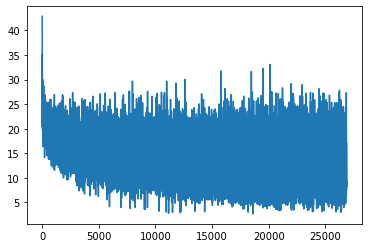

In [31]:
plt.plot(run_hist["loss"]);

In [32]:
def make_prediction(name, model=name_model):
    def single_input_to_tensor(line):
        tensor = np.zeros((1,max_line_size, n_letters), dtype=int)
        for letter_it, letter in enumerate(line):
            if letter_it >= max_line_size:
                break;

            tensor[0][letter_it][letter_to_index(letter)] = 1

        return sg.Variable(tensor)
    def softmaxv2(x):
        """Compute softmax values for each sets of scores in x."""

        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    model_input = single_input_to_tensor(name)
    
    out = model(model_input)
    #print(out)
    probas =  softmaxv2(out.value)
    
    return mapping[np.argmax(probas)+1],np.max(probas)


In [33]:
debug=False

In [34]:
make_prediction("Aqua")

('Italian', 0.44169513442791564)